# goal: Implement sentiment classifier using LSTM neural network

In [1]:
# Import your pytorch tools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# load gensim google vectors
import gensim.downloader as api
word_vectors = api.load('word2vec-google-news-300')



In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
print(device)


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

cuda


# preprocessing

In [3]:
from tqdm import tqdm
# data loading
from nltk.tokenize import TreebankWordTokenizer


# # load gensim google vectors
# word_vectors = api.load('word2vec-google-news-300')


def preprocess_data(filepath):
    """
    load data from file. convert labels from string to numbers
    """
    dataset = pd.read_csv(filepath,skiprows=0)
    # modify  dataset[1] such that positive = 1, negative=0
    dataset["sentiment"] = dataset["sentiment"].map({"positive": 1, "negative": 0})
    return dataset


def tokenize_and_vectorize_sample(sample, max_len=400):
    """
    takes text as input and return word vectors as output
    """
    tokenizer = TreebankWordTokenizer()
    vectorized_data = []
    tokens = tokenizer.tokenize(sample)
    sample_word_vecs = []
    for token in tokens:
        try:
            sample_word_vecs.append((token, word_vectors[token]))
            if len(sample_word_vecs)>= max_len:
                return sample_word_vecs
            # print(f"keeping: {token}")
        except KeyError:
            # print(f"skipping: {token}")
            pass  # No matching token in the Google w2v vocab
    # print(f"sample_words: {sample_words}")
    return sample_word_vecs


dataset = preprocess_data("data/IMDB_Dataset.csv")


# test train split

In [4]:

split_point = int(len(dataset)*.8)

x_train = [sample[0] for i, sample in dataset.iloc[1:split_point,:].iterrows()]
y_train = [sample[1] for i, sample in dataset.iloc[1:split_point,:].iterrows()]

x_test = [sample[0] for i, sample in dataset.iloc[split_point:,:].iterrows()]
y_test = [sample[1] for i, sample in dataset.iloc[split_point:,:].iterrows()]


In [5]:
# tokenize_and_vectorize_sample(x_train[0])
print(len(x_train[0].split()))

162


In [6]:
def generate_batch(x_train, y_train, batch_size):
    next_x_batch, next_y_batch = [], []
    with tqdm(total=len(x_train), position=0, leave=True) as pbar:
        for ip, output in zip(x_train, y_train):
            next_x_batch.append(ip)
            next_y_batch.append(output)
            if len(next_x_batch) == batch_size:
                yield np.array(next_x_batch), np.array(next_y_batch)
                next_x_batch, next_y_batch = [], []
                pbar.update(batch_size)

In [ ]:
# model definition
class LSTM(nn.Module):
    def __init__(self, embedding_dims=300, hidden_dims=100, num_layers=1, batch_first=True):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=embedding_dims,
            hidden_size=hidden_dims,
            num_layers=1,
            batch_first=True,
        )
        self.out = nn.Linear(hidden_dims, 1)
        self.activation = nn.Sigmoid()
        
    
    def forward(self, x):
        r_out, h_n = self.lstm(x, None)
        out = self.out(r_out[:, -1, :])
        out = self.activation(out)
        
        return out



# Experiments
1. Find out words closest to the final state
2. Find out words that displace history the most
3. Find out words that are most displaced from their default position

In [113]:
# model definition used only while inferencing for experimentation
import traceback
import matplotlib.pyplot as plt




def plot_top_k_scores(score_tuples, k=10, key=-2, y_label="scores"):
    """
    plot a bar chart displaying top k words and corresponding scores
    """
    fig, ax = plt.subplots()
    words = [tup[0] for tup in score_tuples[:k]]
    scores = [tup[key] for tup in score_tuples[:k]]
    ax.bar(words, scores)
    ax.set_ylabel(y_label)
    plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')
    plt.show()


def exp_1(func):
    """
    experiment: Find out words closest to the final state
    goal: calculate distance between each default word representation and final output
    assumption: final output should land closer to supporting adjectives and away from non supporting adjectives
    """
    def wrapped(self, *args, **kwargs):
        # print('inside decorator.')
        out, r_out = func(self, *args, **kwargs)
        
        # print(f"r_out.shape: {r_out.shape}")
        
        try:
            text = kwargs.get("text", None)
            x_batch = kwargs.get("x_batch", None)            
            # convert text to x_batch
            if not x_batch and text:
                sample_word_vecs = [tokenize_and_vectorize_sample(sample, max_len=max_len) for sample in [text]]
                word_list = [word for sample in sample_word_vecs for word, *_ in sample]
                x_wordvec_list = [vec for sample in sample_word_vecs for *_, vec in sample]
                x_batch = np.array([x_wordvec_list])
                # x_batch = [pad_trunc(sample, max_len=max_len, embedding_dims=embedding_dims) for sample in x_batch]        
                x_batch = to_device(Variable(torch.FloatTensor(x_batch)), device)
            # print(f"x_batch.shape:{x_batch.shape}")
            
            ###### begin experimental
            # calculate effect of each word without history
            # print(f"x_batch.shape={x_batch.shape}")
            r_singles_hns = [self.lstm(word.unsqueeze(0), None) for word in x_batch.squeeze(0).squeeze(0)]        
            # print(f"r_out.shape: {r_out.shape}")        
            dot_products = [torch.dot(r_singles.squeeze(0),r_out[:,-1, :].squeeze(0)).item() for r_singles,*_ in r_singles_hns]
            # calculate cosine similarity of final snowball with each historyless word effect
            cos = nn.CosineSimilarity(dim=0, eps=1e-6)        
            cos_similarities = [cos(r_singles.squeeze(0),r_out[:,-1, :].squeeze(0)).item() for r_singles,*_ in r_singles_hns]

            # combine position, word, scores for logging purpose
            # word_idx  = [idx for idx,*_ in enumerate(word_list)]
            word_scores = list(set((zip(word_list, dot_products, cos_similarities))))
            word_scores = sorted(word_scores, key=lambda x:-x[-2])
            
            # plot top 10
            plot_top_k_scores(word_scores,k=10,key=-2,  y_label="word_scores")
            word_scores = '\n'.join([str(ws) for ws in word_scores])
            print(text)
            print(f"word_scores: {(word_scores)}")
            
        except Exception as err:
            print(traceback.format_exc())
        # print(f"exiting wrapped")
        return out, r_out 
    return wrapped


def exp_2(func):
    """
    Goal: How much snowball at timestamp t is moved from the word at timestep t
    Experiment: calculate force exerted by history on each word
    assumption: supporting words will be displaced less, opposing words will be displaced more by the history. Displacement means distance between input word and output of a cell
    findings: ?
    """
    def wrapped(self, *args, **kwargs):
        # print('inside decorator.')
        out, r_out = func(self, *args, **kwargs)
        

        try:
            text = kwargs.get("text", None)
            x_batch = kwargs.get("x_batch", None)            
            # convert text to x_batch
            if not x_batch and text:
                sample_word_vecs = [tokenize_and_vectorize_sample(sample, max_len=max_len) for sample in [text]]
                word_list = [word for sample in sample_word_vecs for word, *_ in sample]
                x_wordvec_list = [vec for sample in sample_word_vecs for *_, vec in sample]
                x_batch = np.array([x_wordvec_list])
                # x_batch = [pad_trunc(sample, max_len=max_len, embedding_dims=embedding_dims) for sample in x_batch]        
                x_batch = to_device(Variable(torch.FloatTensor(x_batch)), device)
                        
            # calculate representation of each word without history
            r_singles_hns = [self.lstm(word.unsqueeze(0), None) for word in x_batch.squeeze(0).squeeze(0)]        
            
            
            dot_products = [torch.dot(r_singles.squeeze(0),r_out[:,i, :].squeeze(0)).item() for i, (r_singles,*_) in enumerate(r_singles_hns)]
            
            # calculate cosine similarity of snowball at timestamp t with each historyless word effect
            cos = nn.CosineSimilarity(dim=0, eps=1e-6)        
            cos_similarities = [cos(r_singles.squeeze(0),r_out[:,i, :].squeeze(0)).item() for i, (r_singles,*_) in enumerate(r_singles_hns)]

            # combine position, word, scores for logging purpose
            word_displacements = list(set((zip(word_list, dot_products, cos_similarities))))
            word_displacements = sorted(word_displacements, key=lambda x:-x[-2])
            
            # plot top 10
            plot_top_k_scores(word_displacements,k=10,key=-2, y_label="word_displacements")
            
            word_displacements = '\n'.join([str(wd) for wd in word_displacements])
            print(text)
            print(f"word_displacements: {(word_displacements)}")

            # end experimental
        except Exception as err:
            print(traceback.format_exc())
        
        return out, r_out 
    return wrapped


def exp_3(func):
    """
    Goal: Calculate which words(enforcers) lead to maximum change in cell output/snowball
    assumption: supporting words will be displaced less, opposing words will be displaced more by the history. Displacement means distance between input word and output of a cell
    findings: ?  
    """
    def wrapped(self, *args, **kwargs):
        out, r_out = func(self, *args, **kwargs)
        
        try:
            text = kwargs.get("text", None)
            x_batch = kwargs.get("x_batch", None)            
            # convert text to x_batch
            if not x_batch and text:
                sample_word_vecs = [tokenize_and_vectorize_sample(sample, max_len=max_len) for sample in [text]]
                word_list = [word for sample in sample_word_vecs for word, *_ in sample]
                x_wordvec_list = [vec for sample in sample_word_vecs for *_, vec in sample]
                x_batch = np.array([x_wordvec_list])
                # x_batch = [pad_trunc(sample, max_len=max_len, embedding_dims=embedding_dims) for sample in x_batch]        
                x_batch = to_device(Variable(torch.FloatTensor(x_batch)), device)
            
            total_words = len(list(x_batch.squeeze(0).squeeze(0))
                              
            dot_products = [torch.dot(r_out[:,i, :].squeeze(0), r_out[:,i+1, :].squeeze(0)).item() for i in range(total_words-1)]
            
            # calculate cosine similarity between two adjacent cell outputs
            cos = nn.CosineSimilarity(dim=0, eps=1e-6)        
            cos_similarities = [cos(r_out[:,i, :].squeeze(0), r_out[:,i+1, :].squeeze(0)).item() for i in range(total_words-1)]

            # combine position, word, scores for logging purpose
            # word_idx  = [idx for idx,*_ in enumerate(word_list)]
            history_displacements = list(set((zip(word_list[1:], dot_products, cos_similarities))))
            history_displacements = sorted(history_displacements, key=lambda x:-x[-2])
            
            plot_top_k_scores(history_displacements,k=10,key=-2, y_label="history_displacements")
            
            history_displacements = '\n'.join([str(wd) for wd in history_displacements])
            print(text)
            print(f"history_displacements: {(history_displacements)}")

            # end experimental
        except Exception as err:
            print(traceback.format_exc())
        return out, r_out 
    return wrapped


class ExperimentalLSTM(nn.Module):
    def __init__(self, embedding_dims=300, hidden_dims=100, num_layers=1, batch_first=True):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=embedding_dims,
            hidden_size=hidden_dims,
            num_layers=1,
            batch_first=True,
        )
        
        self.out = nn.Linear(hidden_dims, 1)
        
        self.activation = nn.Sigmoid()
        
    
    
    # use decorator for experimentation during inference 
    @exp_3
    def forward(self, text:str="", x_batch=None):
        #1.  get words,vecs from text
        
        #TODO: avoid repetetion
        #if True: #not x_batch and text:            
        sample_word_vecs = [tokenize_and_vectorize_sample(sample, max_len=max_len) for sample in [text]]
        word_list = [word for sample in sample_word_vecs for word, *_ in sample]
        x_wordvec_list = [vec for sample in sample_word_vecs for *_, vec in sample]
        
        x_batch = np.array([x_wordvec_list])
        # x_batch = [pad_trunc(sample, max_len=max_len, embedding_dims=embedding_dims) for sample in x_batch]        
        x_batch = to_device(Variable(torch.FloatTensor(x_batch)),device)
        
        # print(f"calling self.lstm")
        r_out, h_n = self.lstm(x_batch, None)
        print(f"r_out.shape:{r_out.shape}")

        out = self.out(r_out[:, -1, :])
        out = self.activation(out)
        return out, r_out #final outputs and intermediate histories(r_out)



In [114]:
embedding_dims=300
hidden_dims= 100
num_layers=2
batch_first=True
max_len=400
epochs = 5
batch_size=1

# Training

In [ ]:
# Instantiate the model

lstm_model = LSTM(embedding_dims=300, hidden_dims=100, num_layers=num_layers, batch_first=True)
lstm_model = to_device(lstm_model, device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(lstm_model.parameters())


# Training loop
num_epochs = epochs  # Example value for epochs
for epoch in tqdm(range(num_epochs)):
    lstm_model.train()     
    loss_val = 0
    for i, (x_batch, y_batch) in enumerate(generate_batch(x_train, y_train, batch_size=batch_size)):
        # print(i)
        x_batch = [tokenize_and_vectorize_sample(sample) for sample in x_batch]
        x_batch = Variable(torch.FloatTensor(x_batch))
        x_batch = to_device(x_batch, device)
        # x_batch = x_batch.permute(0, 2, 1)
        # print(x_batch.shape)
        y_batch = to_device(Variable(torch.FloatTensor(np.array([y_batch]))), device)
        y_batch = y_batch.reshape(batch_size,1)
        outputs = lstm_model(x_batch)
        # print(outputs)
        # print(y_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        loss_val += loss.item()
        optimizer.step()
        # if i==20000:
        #     break
    print(f"epoch({epoch}): total_loss={loss_val}")
    loss_val=0

In [ ]:
# save pytorch model
# saving embeddings
model_path = f"imdb_lstm_model_{max_len}_{embedding_dims}_{hidden_dims}_{num_layers}.pth"
torch.save(lstm_model.state_dict(), model_path)

In [115]:
# Load the model from the file
model_path = f"imdb_lstm_model_{max_len}_{embedding_dims}_{hidden_dims}_{num_layers}.pth"
loaded_model = ExperimentalLSTM(embedding_dims=embedding_dims, hidden_dims=hidden_dims, num_layers=num_layers)  # Create an instance of your model
loaded_model.load_state_dict(torch.load(model_path))  # Load the state dictionary
loaded_model.eval()  # Set the model to evaluation mode
loaded_model = to_device(loaded_model, device)
# Now 'loaded_model' contains the model loaded from the saved file


# evaluation

In [ ]:
# evaluation
import torch
from sklearn.metrics import accuracy_score

# Load the model and prepare input data (as shown in the previous responses)

def evaluate(x_test, y_test, batch_size=1):
    print(f"len(x_test) == len(y_test): {len(x_test)} == {len(y_test)}")
    predictions = []
    batches = int(len(x_test)/batch_size) +1
    for i in tqdm(range(batches)):
        x_batch = x_test[i:i+batch_size]
        y_batch = y_test[i:i+batch_size]
        
        if not x_batch or not y_batch:
            break
        
        x_batch = [tokenize_and_vectorize_sample(sample, max_len=max_len) for sample in x_batch]
        
        x_batch = Variable(torch.FloatTensor(x_batch))
        x_batch = to_device(x_batch, device)
        
        
        y_batch = to_device(Variable(torch.FloatTensor([y_batch])), device)
        y_batch = y_batch.reshape(batch_size,1)
        y_batch = to_device(y_batch, device)
        # print(x_batch.shape)
        # Perform inference on the test data
        with torch.no_grad():
            # Forward pass to get predictions
            batch_predictions = loaded_model(x_batch)
            # print(f"batch_predictions: {batch_predictions}")
            # Assuming 'predictions' is the model's predictions (binary values)
            # print(predictions)
            # Convert predictions to binary values based on a threshold (e.g., 0.5 for binary classification)
            threshold = 0.5
            binary_predictions = (batch_predictions > threshold).float()
            binary_predictions = [bp.squeeze(0).cpu() for bp in binary_predictions]
            # print(f"binary_predictions.squeeze(): {binary_predictions.squeeze()}")
            predictions.extend(binary_predictions)
            
            # print(f"len(binary_predictions):{len(binary_predictions)}")
    
    total = min(len(y_test), len(predictions))
    # print(y_test[:total])
    # print(predictions[:total])
    accuracy = accuracy_score(y_test[:total], predictions[:total])
    
    print("Accuracy:", accuracy)

evaluate(x_test, y_test)
# print(type(x_test))

# inference

In [ ]:
def inference(text):
    sample_word_vecs = [tokenize_and_vectorize_sample(sample, max_len=max_len) for sample in [text]]
    word_list = [word for sample in sample_word_vecs for word, *_ in sample]
    x_wordvec_list = [vec for sample in sample_word_vecs for *_, vec in sample]
    print(f"len(x_wordvec_list): {len(x_wordvec_list)}")
    print(f"type(x_wordvec_list[0]): {type(x_wordvec_list[0])}")
    print(word_list)
    x_batch = np.array([x_wordvec_list])
    # x_batch = [pad_trunc(sample, max_len=max_len, embedding_dims=embedding_dims) for sample in x_batch]        
    x_batch = to_device(Variable(torch.FloatTensor(x_batch)),device)
    # x_batch = x_batch.permute(0, 2, 1)
    # print(x_batch.shape)
    # Perform inference
    with torch.no_grad():
        # Forward pass to get predictions
        predictions = loaded_model(x_batch)
        # If you're doing binary classification (as in your original Keras model)
        # You may want to threshold the predictions to get the final classes
        # Assuming a threshold of 0.5 for binary classification
        # print(predictions)
        threshold = 0.5
        binary_predictions = (predictions > threshold).float()
        return binary_predictions

review = inference("""Movie was good and it felt like a good movie""")

print(review)

# print(x_train[1])


sample_id:26046
actual:[1]
inside forward
r_out.shape:torch.Size([1, 125, 100])
leaving forward


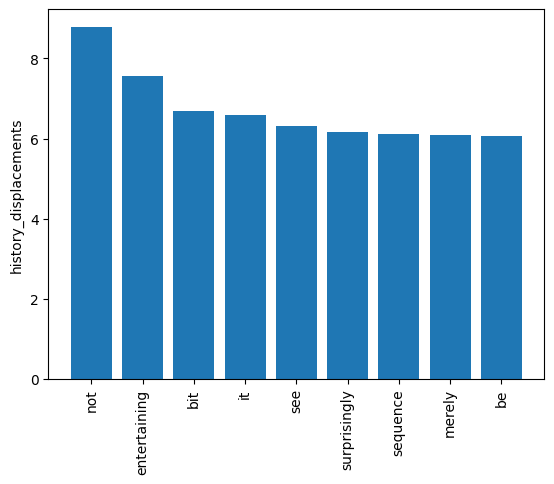

tom had a wish to make film for a long time and he did. it is as if he has visualized a dirty and worn out notebook full of great little ideas he has been filling up and carrying around for 10 years. no grant character transformations, no Hollywood ingredients just life and a little bit of magic. the balance, in speed, in weirdness in comedy vs drama is perfectly weighed. this film takes you on a journey that is over before you realize how nice it was. the music is great and your eyes will be equally satisfied. the fact that this film is about nothing, merely a sequence of sketches of people that are mainly linked trough a party of one of the characters, makes it very pleasant and surprisingly entertaining, it is brilliant because it is empty. in between the lines it is happening. to see or not to see, that's the ?
history_displacements: ('not', 8.78446102142334, 0.823113203048706)
('entertaining', 7.553743362426758, 0.7668375968933105)
('bit', 6.683976173400879, 0.8900999426841736)
('

In [116]:
from random import randrange
from termcolor import colored
import re
def experimental_inference(text):
    # x_batch = x_batch.permute(0, 2, 1)
    # print(x_batch.shape)
    # Perform inference
    with torch.no_grad():
        # Forward pass to get predictions
        predictions, *_ = loaded_model(text=text, x_batch=None)
        # If you're doing binary classification (as in your original Keras model)
        # You may want to threshold the predictions to get the final classes
        # Assuming a threshold of 0.5 for binary classification
        print(predictions)
        threshold = 0.5
        binary_predictions = (predictions > threshold).float()
        return binary_predictions

# print(x_test[1])
texts = [
    "movie was terrible and acting was great.",
    "acting was great and movie was terrible."
    
]


sample_id = randrange(len(x_train))
print(f"sample_id:{sample_id}")

for text in x_train[sample_id:sample_id+1]:
    try:
        # print(f"{text}")
        print(f"actual:{y_train[sample_id:sample_id+1]}")        
        text = re.sub('<[^<]+?>', '', text)
        review = experimental_inference(text)        
        print(f"predicted: {review}")        
        print("="*100)
    except Exception as err:
        pass
    
# 
